In [1]:
import numpy as np
from google.colab import drive
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns


from textwrap import wrap
from tensorflow.keras.utils import plot_model
plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

In [2]:
# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# Path to dataset folder
image_path = '/content/drive/MyDrive/Images1'

In [4]:
CapData = pd.read_excel('/content/drive/MyDrive/captions-16.xlsx')
CapData.head()

,id,image,caption
0,1,image_1.jpg,A beautiful young girl posing on a white backg...
1,2,image_2.jpg,A man thinking with a white mask
2,3,image_3.jpg,Medical stitches - puncture wound closed up
3,4,image_4.jpg,"One hand pointing, finger out, thumb up"
4,5,image_5.jpg,my hand compared to ancient handprints of anas...


In [5]:
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.

    return img

In [6]:
def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(image_path + "/" + temp_df['image'][i])
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

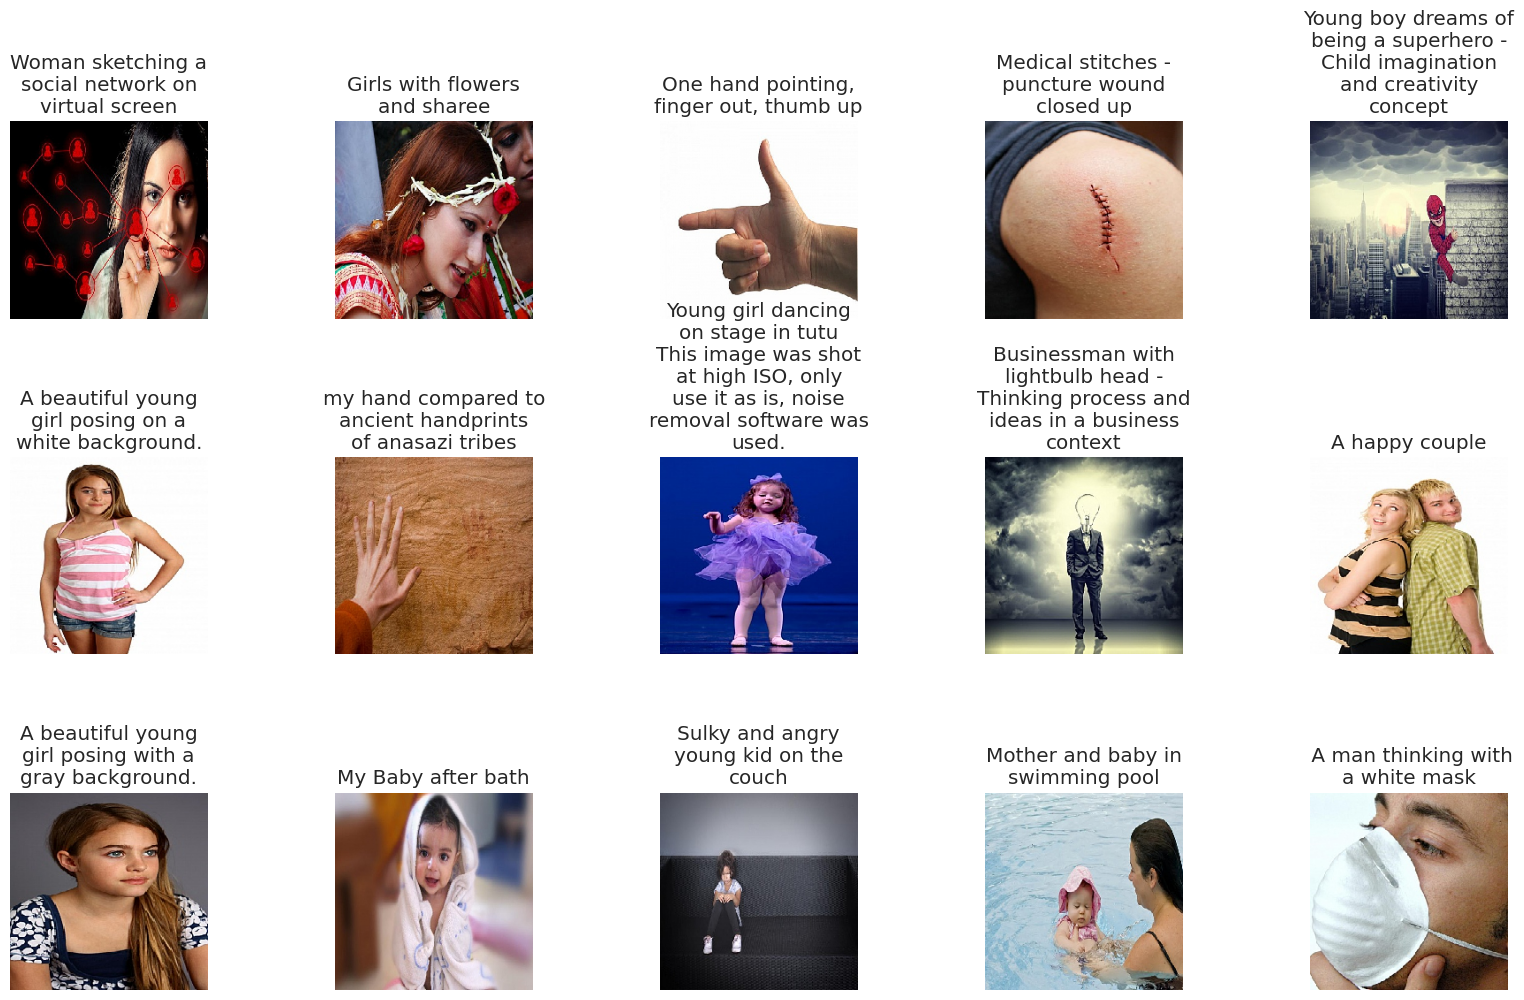

In [7]:
display_images(CapData.sample(15))

In [8]:
import re

def text_preprocessing(data):
    # Pre-compile the regular expressions for efficiency
    non_alpha_regex = re.compile("[^A-Za-z]")
    whitespace_regex = re.compile("\s+")

    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: whitespace_regex.sub(" ", non_alpha_regex.sub(" ", x)).strip())
    data['caption'] = "#" + data['caption'] + "."

    return data

In [9]:
Predata = text_preprocessing(CapData)
captions = Predata['caption'].tolist()
captions[:10]

['#a beautiful young girl posing on a white background.',
 '#a man thinking with a white mask.',
 '#medical stitches puncture wound closed up.',
 '#one hand pointing finger out thumb up.',
 '#my hand compared to ancient handprints of anasazi tribes.',
 '#a beautiful young girl posing with a gray background.',
 '#sulky and angry young kid on the couch.',
 '#mother and baby in swimming pool.',
 '#young girl dancing on stage in tutu this image was shot at high iso only use it as is noise removal software was used.',
 '#my baby after bath.']

In [10]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer

# Assuming CapData is your DataFrame containing image paths and captions

# Check data consistency
assert len(CapData['image'].unique()) == len(CapData), "Duplicate images in the dataset."

# Split data into train and test sets
train_data, test_data = train_test_split(CapData, test_size=0.15, random_state=42)

# Tokenization on train set
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data['caption'])

# Vocab size and max length
vocab_size = len(tokenizer.word_index) + 1
max_length = max([len(caption.split()) for caption in train_data['caption']])

# Process images
train_images = train_data['image'].unique()
test_images = test_data['image'].unique()

# Filter data for train and test sets
train = train_data[train_data['image'].isin(train_images)].reset_index(drop=True)
test = test_data[test_data['image'].isin(test_images)].reset_index(drop=True)

# Function to preprocess a list of captions using the trained tokenizer
def preprocess_captions(captions_list):
    return tokenizer.texts_to_sequences(captions_list)

# Example usage
sample_captions = [train['caption'][0], test['caption'][0]]
preprocessed_sample = preprocess_captions(sample_captions)
print(preprocessed_sample)

[[3, 13, 14, 6, 15, 2, 16, 17, 18, 1, 19, 20], [2, 3, 26, 4, 2]]


In [11]:
test.shape

(3, 3)

In [12]:
model = DenseNet201()
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

img_size = 224
features = {}
for image in tqdm(CapData['image'].unique().tolist()):
    img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    img = np.expand_dims(img,axis=0)
    feature = fe.predict(img, verbose=0)
    features[image] = feature

82524592/82524592 [==============================] - 3s 0us/step


100%|██████████| 16/16 [00:13<00:00,  1.21it/s]


In [13]:
class CustomDataGenerator(Sequence):

    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer,
                 vocab_size, max_length, features, shuffle=True):

        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
        return self.n // self.batch_size


    def __getitem__(self, index):
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size, :]
        X1, X2, y = self.__get_data(batch)
        y_real = np.ones((X1.shape[0], 1))  # Create a label array for the real data (ones)
        return (X1, X2), y, y_real  # Return X1, X2, y, and y_real together

    def __get_data(self, batch):
        X1, X2, y = list(), list(), list()
        images = batch[self.X_col].tolist()

        for image in images:
            feature = self.features[image][0]
            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)

        X1, X2, y = np.array(X1), np.array(X2), np.array(y)

        return X1, X2, y

In [14]:
def build_collaborative_model(vocab_size, max_length, img_feature_size):
    # Image Feature Encoder
    input1 = Input(shape=(img_feature_size,))
    img_features = Dense(256, activation='relu')(input1)
    img_features_reshaped = Reshape((1, 256), name='img_features_reshaped')(img_features)

    # Text Sequence Encoder
    input2 = Input(shape=(max_length,))
    sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)

    # Merge Image and Text Features
    merged = concatenate([img_features_reshaped, sentence_features], axis=1)

    # LSTM and Dense Layers
    sentence_features = LSTM(256, name='caption_lstm')(merged)
    x = Dropout(0.5)(sentence_features)
    x = add([x, img_features])
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)

    # Output Layer
    output = Dense(vocab_size, activation='softmax', name='caption_output')(x)

    # Combine Image and Text Inputs
    collaborative_model = Model(inputs=[input1, input2], outputs=output)
    return collaborative_model


In [15]:
def build_discriminator(vocab_size, max_length):
    model = Sequential()
    model.add(Embedding(vocab_size, 256, input_length=max_length))
    model.add(LSTM(256))
    model.add(Dense(1, activation='sigmoid'))
    return model


def build_gan(generator, discriminator):
    discriminator.trainable = False
    gan_input = generator.input
    x = generator.output
    gan_output = discriminator(x)
    gan_model = Model(gan_input, gan_output)
    return gan_model



In [16]:
def get_image_features(data, image_path, img_size):
    features = {}
    model = DenseNet201()
    fe = Model(inputs=model.input, outputs=model.layers[-2].output)

    for image in tqdm(data['image'].unique().tolist()):
        img = load_img(os.path.join(image_path, image), target_size=(img_size, img_size))
        img = img_to_array(img)
        img = img / 255.
        img = np.expand_dims(img, axis=0)
        feature = fe.predict(img, verbose=0)
        features[image] = feature[0]

    return features

In [17]:
from keras.models import Model
from keras.layers import Input, Dense, Embedding, LSTM, Dropout, Add, Concatenate

def build_caption_generator(vocab_size, max_length, img_feature_size):
    # Image feature input
    image_input = Input(shape=(img_feature_size,), name='input_24')
    dense_image = Dense(256, activation='relu', name='dense_31')(image_input)
    image_feature = Reshape((1, 256), name='img_features_reshaped')(dense_image)

    # Caption input
    caption_input = Input(shape=(max_length,), name='input_25')
    caption_embedding = Embedding(input_dim=vocab_size, output_dim=256, name='embedding_11')(caption_input)

    # Concatenate image feature and caption input
    concat_input = Concatenate(axis=1, name='concatenate_11')([image_feature, caption_embedding])

    # LSTM layer
    lstm_layer = LSTM(256, name='caption_lstm')(concat_input)

    # Dropout layer
    dropout_layer = Dropout(0.5, name='dropout_22')(lstm_layer)

    # Add image feature to dropout layer
    add_layer = Add(name='add_11')([dropout_layer, dense_image])

    # Dense layer
    dense_layer1 = Dense(128, activation='relu', name='dense_32')(add_layer)

    # Final output layer
    output_layer = Dense(vocab_size, activation='softmax', name='caption_output')(dense_layer1)

    # Create the model
    caption_generator = Model(inputs=[image_input, caption_input], outputs=output_layer, name='caption_generator')
    return caption_generator


In [18]:
def save_generated_captions(generator, tokenizer, epoch, X_real, max_length, output_dir='generated_captions'):
    os.makedirs(output_dir, exist_ok=True)

    for i in range(10):  # Generate and save captions for 10 sample images
        # Generate noise
        noise = np.random.rand(1, max_length)

        # Generate fake captions using the generator model
        fake_captions = generator.predict([X_real, noise])
        fake_captions = pad_sequences(fake_captions, maxlen=max_length, padding='post')

        # Convert token indices back to words
        generated_caption = " ".join([tokenizer.index_word[token_idx] for token_idx in fake_captions[0] if token_idx != 0])

        # Save generated caption to a file
        output_file = os.path.join(output_dir, f"generated_caption_epoch{epoch}_sample{i}_{int(time.time())}.txt")
        with open(output_file, 'w') as f:
            f.write(generated_caption)

In [19]:
def idx_to_word(integer,tokenizer):

    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

In [20]:
def predict_caption(model, image, tokenizer, max_length, features, record):
    image_filename = os.path.basename(record[1]['image'])  # Access row data using record[1]
    feature = features[image_filename]
    in_text = "#"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)

        y_pred = model.predict([feature, sequence])
        y_pred = np.argmax(y_pred)

        word = idx_to_word(y_pred, tokenizer)  # You need to implement idx_to_word

        if word is None:
            break

        in_text += " " + word  # Use a single space here

        if word == ".":
            break

    return in_text



Sample Records:    id        image                                            caption
0   1  image_1.jpg  #a beautiful young girl posing on a white back...
1   2  image_2.jpg                 #a man thinking with a white mask.
Processing Image: image_1.jpg
1/1 [==============================] - 0s 20ms/step
Token Index Before idx_to_word: 0
Image Filename: image_1.jpg
Predicted Caption: # high high high high high high high high high high high high high high high high high high high high high high high high
Predicted Word: None
Processing Image: image_2.jpg
1/1 [==============================] - 0s 20ms/step
Token Index Before idx_to_word: 0
Image Filename: image_2.jpg
Predicted Caption: # out out out out hand out out hand out hand out hand out hand out hand out hand out hand out hand out hand
Predicted Word: None


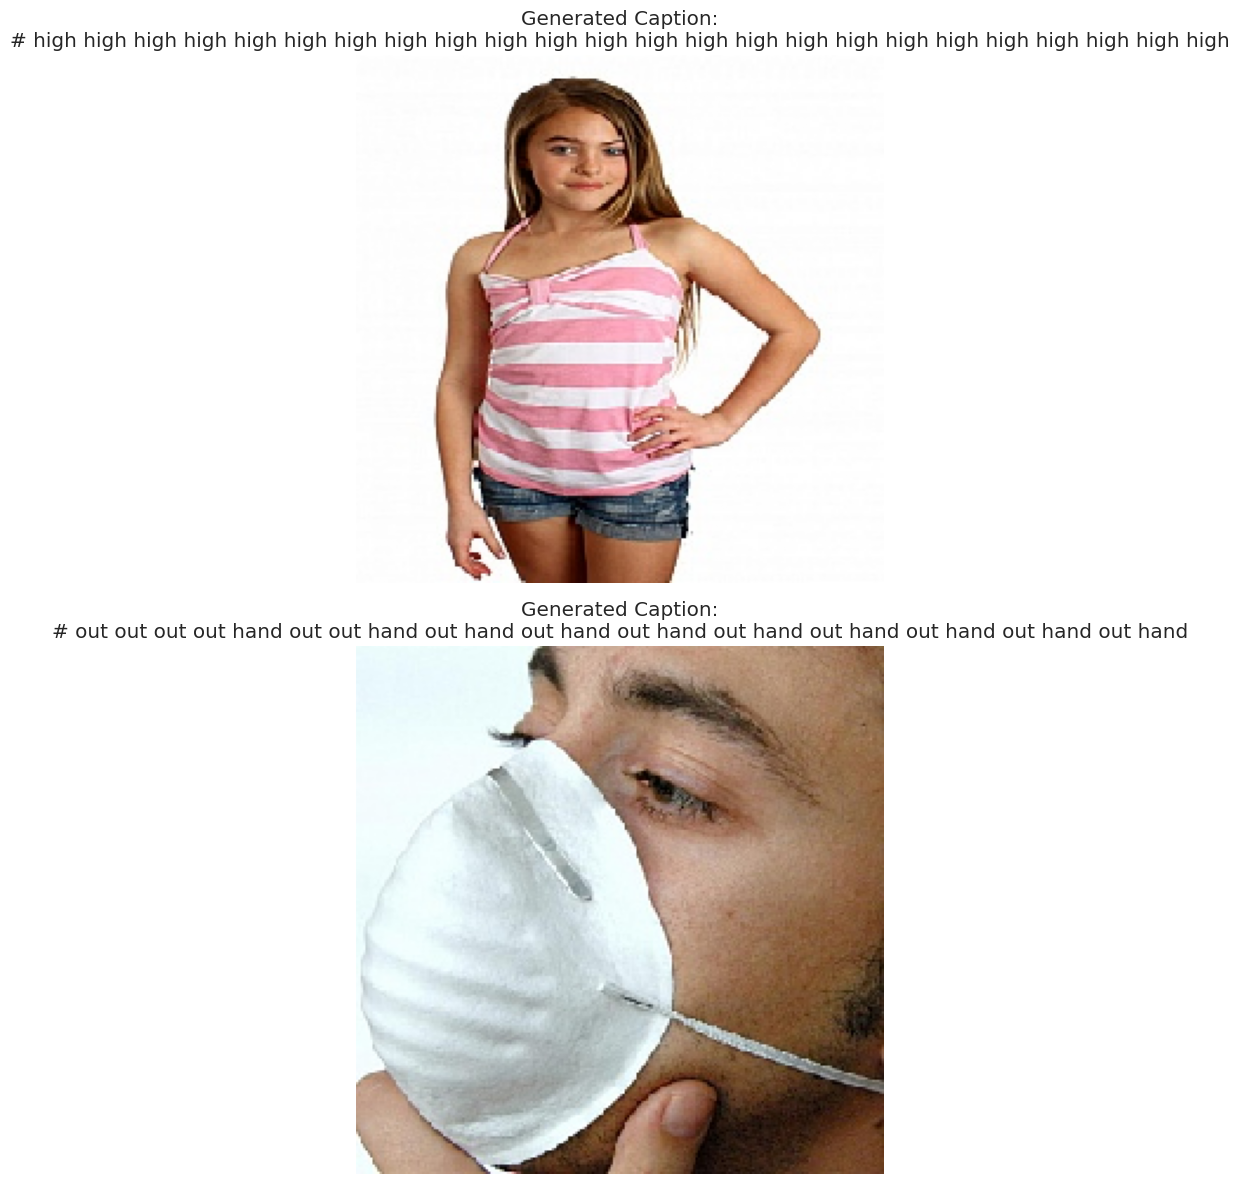

In [30]:
def main():
    # Load and preprocess your data (data DataFrame and captions list)
      # ...
  # Set parameters
  img_size = 224
  batch_size = 64
  vocab_size = len(tokenizer.word_index) + 1

  # Build the collaborative model
  collaborative_model = build_collaborative_model(vocab_size, max_length, img_feature_size=1920)

  # Build the discriminator
  discriminator = build_discriminator(vocab_size, max_length)

  # Build the GAN model
  gan_model = build_gan(collaborative_model, discriminator)

  # Print the GAN model summary
  gan_model.summary()

  # Print the model summary
  collaborative_model.summary()

  # Create data generators
  train_data_generator = CustomDataGenerator(df=train, X_col='image', y_col='caption',
                                            batch_size=batch_size, directory=image_path,
                                            tokenizer=tokenizer, vocab_size=vocab_size,
                                            max_length=max_length, features=features)
  test_data_generator = CustomDataGenerator(df=test, X_col='image', y_col='caption',
                                            batch_size=batch_size, directory=image_path,
                                            tokenizer=tokenizer, vocab_size=vocab_size,
                                            max_length=max_length, features=features)

  # Training loop
  num_epochs = 10
  for epoch in range(num_epochs):
      print(f"Epoch {epoch + 1}/{num_epochs}")
      for step in range(len(train_data_generator)):

            # Train discriminator on real data
            # Inside the training loop
            # Get data from the generator
            X_real, captions, y, y_real = train_data_generator[step]  # Unpack the generator's output correctly

            # Generate noise for each batch with correct batch size (match batch size)
            noise = np.random.rand(X_real.shape[0], max_length)

            # Generate fake captions using the collaborative model (generator part)
            fake_captions = collaborative_model.predict([X_real, noise])

            # Truncate or pad the fake_captions to match the length of captions
            fake_captions = pad_sequences(fake_captions, maxlen=max_length, padding='post')

            # Create labels for real and fake captions
            # Use np.ones_like for y_real to represent real captions (labels=1)
            # Use np.zeros_like for fake_captions to represent generated captions (labels=0)
            labels_real = np.ones_like(captions)
            labels_fake = np.zeros_like(fake_captions)

            # Concatenate real and fake captions and labels for training discriminator
            captions_combined = np.concatenate([captions, fake_captions], axis=0)
            labels_combined = np.concatenate([labels_real, labels_fake], axis=0)

            # Ensure the number of samples in captions_combined is twice the original captions size
            assert captions_combined.shape[0] == 2 * captions.shape[0]

            # Train the discriminator
            d_loss = collaborative_model.train_on_batch([X_real, captions_combined], labels_combined)



            # Shuffle data to prevent overfitting
            indices = np.arange(len(captions_combined))
            np.random.shuffle(indices)
            captions_combined = captions_combined[indices]
            labels_combined = labels_combined[indices]

            # Train the discriminator
            d_loss = collaborative_model.train_on_batch([X_real, captions_combined], labels_combined)

            # Train the generator (GAN model)
            valid_labels = np.ones((X_real.shape[0], 1))
            g_loss = gan_model.train_on_batch([X_real, noise], valid_labels)

            print(f"Step {step + 1}/{len(train_data_generator)} | D Loss: {d_loss} | G Loss: {g_loss}")

            if (epoch + 1) % 10 == 0:
                save_generated_captions(collaborative_model, tokenizer, epoch, X_real, max_length, output_dir='generated_captions')



if __name__ == '__main__':

    # Build the collaborative model
    collaborative_model = build_collaborative_model(vocab_size, max_length, img_feature_size=1920)

    collaborative_model.save('collaborative_model.h5')
# Select two sample images from the test set
sample_indices = [0, 1]  # Change these indices to select different samples
sample_records = test.iloc[sample_indices]

# Print the sample_records variable before the loop to confirm its contents
print("Sample Records:", sample_records)

# Create a figure to display the images and captions in a vertical layout
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 12))



for i, record in enumerate(sample_records.iterrows()):
    index, data = record
    img = load_img(os.path.join(image_path, data['image']), target_size=(224, 224))
    img = img_to_array(img)
    img = img / 255.

    # Print the image filename being processed
    print("Processing Image:", data['image'])

    caption = predict_caption(collaborative_model, img, tokenizer, max_length, features, record)

    # Print the token index just before calling idx_to_word
    token_index = np.argmax(tokenizer.texts_to_sequences([caption])[0])
    print(f"Token Index Before idx_to_word: {token_index}")

    # Get the corresponding word using the idx_to_word function
    word = idx_to_word(token_index, tokenizer)

    # Display the image and caption in the subplot
    ax = axes[i]
    ax.imshow(img)
    ax.set_title("Generated Caption:\n" + caption)
    ax.axis('off')

    # Add print statements for the predicted caption
    print(f"Image Filename: {data['image']}")
    print(f"Predicted Caption: {caption}")
    print(f"Predicted Word: {word}")  # Add this print statement

plt.tight_layout()
plt.show()

